In [1]:
import argparse
from typing import Literal
from pathlib import Path

import torch
import intel_extension_for_pytorch as ipex
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from PIL import Image
from PIL.ImageFile import ImageFile

from tqdm import tqdm
from torchvision import transforms as T

from dataloader import ImageDataset, TransformWrapper



/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
sample_pth = Path('/home/tsakalis/ntua/phd/cellforge/cellforge/data/the_perfect_candidate/the_perfect_candidate')

In [3]:
image_file_paths = sorted(list((sample_pth).glob('*.jpg')),
key=lambda x: int(x.stem.split('_')[0]))

In [4]:
image_size = 224

In [5]:
normalize_tensor = T.Compose([
    T.Lambda(lambda x: x.resize(
        (image_size, image_size), Image.Resampling.LANCZOS)),
    T.Lambda(lambda x: x.convert("RGB")),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x[:1, :]),
])

In [6]:
from torch.utils import data

In [7]:
dataloader = data.DataLoader(
    [normalize_tensor(Image.open(img)) for img in image_file_paths[-300:]],
    shuffle=False,
    batch_size=12)

In [8]:
inner_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
)

whole_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
)

In [9]:
model_weights_pth =Path('/home/tsakalis/ntua/phd/cellforge/cellforge/model_weights/')

In [ ]:
inner_model.load_state_dict(
    torch.load(
        model_weights_pth/'inner_embryo.pt', map_location='cpu'
    ))

whole_model.load_state_dict(
    torch.load(
        model_weights_pth/'full_embryo.pt', map_location='cpu'
    ))

/tmp/ipykernel_145594/2700298292.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(
/tmp/ipykernel_145594/2700298292.py:7: FutureWarning: You are using `torch.l

<All keys matched successfully>

In [11]:
device = 'cpu'

inner_model.eval()
whole_model.eval()

inner_model.to(device)
whole_model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [12]:
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy()

In [13]:
from tqdm import tqdm

In [14]:
inner_model_compiled = torch.compile(inner_model)
whole_model_compiled = torch.compile(whole_model)

In [19]:
all_zps = []
for batch in tqdm(dataloader):

    mask_inner = torch.sigmoid(inner_model_compiled(batch.to(device)))
    mask_whole = torch.sigmoid(whole_model_compiled(batch.to(device)))

    zps = (mask_whole>0.5).double() - (mask_inner>0.5).double()

    all_zps.append(tensor_to_numpy(zps))


100%|██████████| 25/25 [00:04<00:00,  6.05it/s]


In [21]:
import numpy as np

all_zps_ar = np.vstack(all_zps)

In [17]:
tensor_arr_normalized = ((all_zps_ar + 1) / 2) * 255
threshold = 128
binary_mask = (tensor_arr_normalized > threshold).astype(np.uint8) * 255

NameError: name 'all_zps_ar' is not defined

In [23]:
import numpy as np
import cv2

# Assume `tensor` is your NumPy array of shape (150, 1, 224, 224)
tensor_arr_normalized = ((all_zps_ar + 1) / 2) * 255
threshold = 128
binary_mask = (tensor_arr_normalized > threshold).astype(np.uint8) * 255
frames = np.squeeze(binary_mask, axis=1)

# Define the output video parameters
output_file = 'output_video.mp4'
frame_height, frame_width = frames.shape[1], frames.shape[2]
fps = 20  # Frames per second

# Define video codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' for .mp4
out = cv2.VideoWriter(output_file,
                      fourcc,
                      fps, (frame_width, frame_height),
                      isColor=False)

# Write each frame to the video
for frame in frames:
    out.write(frame)

# Release the VideoWriter
out.release()

print(f"Video saved as {output_file}")


Video saved as output_video.mp4


In [24]:
import numpy as np
from PIL import Image

# Assuming `tensor_arr` is your NumPy array with shape (150, 1, 224, 224) in range [-1, 1]

# Step 3: Remove the channel dimension to get (150, 224, 224)
frames = np.squeeze(binary_mask, axis=1)

# Step 4: Convert each frame to a Pillow Image and save as GIF
images = [Image.fromarray(frame, mode='L')
          for frame in frames]  # 'L' mode for grayscale
output_gif = 'output_animation.gif'
images[0].save(
    output_gif,
    save_all=True,
    append_images=images[1:],
    duration=100,  # Duration for each frame in milliseconds (adjust as needed)
    loop=0)  # Loop forever (set to `1` for no looping)import cv2)
print(f"GIF saved as {output_gif}")


GIF saved as output_animation.gif


In [25]:
import matplotlib.pyplot as plt

In [26]:
binary_mask.shape

(300, 1, 224, 224)

In [27]:
np.where(binary_mask[0,0] == 255)

(array([ 49,  49,  49, ..., 176, 176, 176], shape=(6675,)),
 array([113, 114, 115, ..., 116, 117, 118], shape=(6675,)))

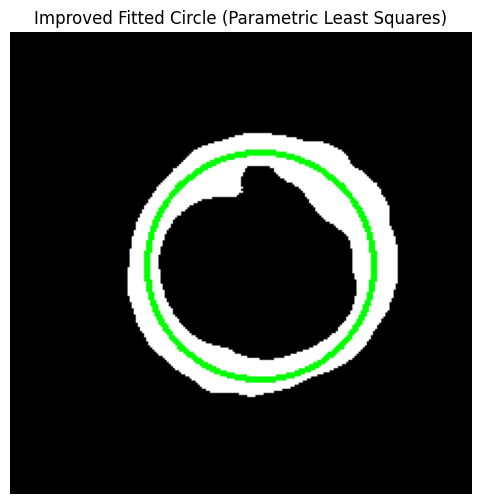

(np.float64(121.10840380757577),
 np.float64(113.48432685532136),
 np.float64(55.341731305886384))

In [28]:
from scipy.optimize import leastsq

def algebraic_circle_fit(x, y):
    """
    Perform least-squares fitting of a circle to given (x, y) points.
    Returns the center (xc, yc) and radius r.
    """
    def calc_radius(xc, yc):
        return np.sqrt((x - xc)**2 + (y - yc)**2)

    def cost(params):
        xc, yc = params
        radii = calc_radius(xc, yc)
        return radii - radii.mean()

    # Initial guess for the center
    x_m, y_m = np.mean(x), np.mean(y)
    center, _ = leastsq(cost, (x_m, y_m))
    xc, yc = center
    radii = calc_radius(xc, yc)
    r = radii.mean()
    return xc, yc, r

# Extract points from the binary mask (white pixels)
y_coords, x_coords = np.where(binary_mask[0,0] == 255)

# Fit a parametric circle to the data
xc, yc, radius = algebraic_circle_fit(x_coords, y_coords)

# Create an overlay with the fitted parametric circle
overlay_image = np.dstack([binary_mask[0,0]] * 3)  # Convert to RGB

# Draw the fitted circle
cv2.circle(overlay_image, (int(xc), int(yc)), int(radius), (0, 255, 0), 2)  # Green

# Display the result
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(overlay_image)
ax.set_title("Improved Fitted Circle (Parametric Least Squares)")
plt.axis("off")
plt.show()

# Return circle parameters for verification
xc, yc, radius


In [29]:
def calculate_radiuses(x_coords, y_coords):
    # Calculate the distances of all white boundary pixels from the circle center
    distances = np.sqrt((x_coords - xc)**2 + (y_coords - yc)**2)

    # Find the "true" outer radius based on the maximal distances (fullest thickness)
    outer_radius = np.max(distances)
    inner_radius = outer_radius - np.max(distances - radius)

    # Compute the thickness as the difference
    thickness_values = distances - radius  # Thickness at each point
    thickness_mean = np.mean(thickness_values[thickness_values > 0])  # Exclude artifacts (negative values)
    thickness_variance = np.var(thickness_values[thickness_values > 0])

    return outer_radius, inner_radius, thickness_mean, thickness_variance


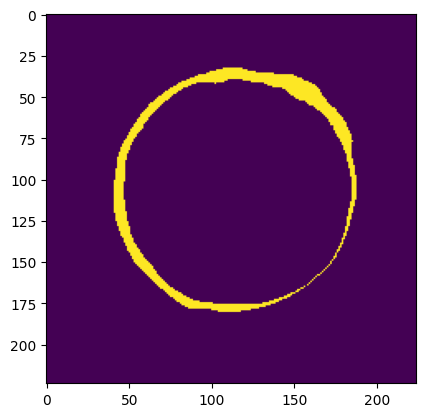

In [30]:
plt.imshow(binary_mask[230,0])

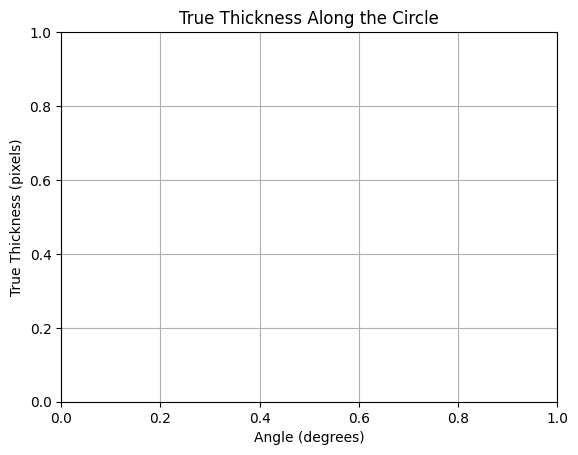

In [43]:
# Define the angular intervals for measuring thickness
import numpy as np
angles = np.linspace(0, 2 * np.pi, 60)  # 360 angular intervals
mean_thicknesses = []
for i in range(100,299):
    thicknesses = []
    binary = binary_mask[i,0]

    y_coords, x_coords = np.where(binary == 255)

    outer_radius, inner_radius, thickness_mean, thickness_variance = calculate_radiuses(x_coords, y_coords)
    # Iterate over each angle and calculate true thickness
    for angle in angles:
        # Compute ray endpoints based on the angle
        ray_x = int(xc + outer_radius * np.cos(angle))
        ray_y = int(yc + outer_radius * np.sin(angle))
        
        # Traverse along the ray to find outer and inner boundary points
        points_on_ray = []
        for t in np.linspace(0, outer_radius, 500):
            x = int(xc + t * np.cos(angle))
            y = int(yc + t * np.sin(angle))
            if 0 <= x < binary.shape[1] and 0 <= y < binary.shape[0]:
                if binary[y, x] == 255:
                    points_on_ray.append((x, y))
        
        # If points are found, calculate distances to the center
        if len(points_on_ray) > 1:
            distances = [np.sqrt((px - xc)**2 + (py - yc)**2) for px, py in points_on_ray]
            thickness = max(distances) - min(distances)  # True thickness
            thicknesses.append(thickness)
        else:
            thicknesses.append(0)
    

    mean_thicknesses.append((np.mean(thicknesses), np.std(thicknesses)))
    # Convert angles to degrees for plotting
    angles_deg = np.degrees(angles)

    # Plot the thickness profile
    # plt.figure(figsize=(8, 4))
    # plt.plot(angles_deg, thicknesses)
    
plt.xlabel("Angle (degrees)")
plt.ylabel("True Thickness (pixels)")
plt.title("True Thickness Along the Circle")
plt.grid(True)
plt.show()


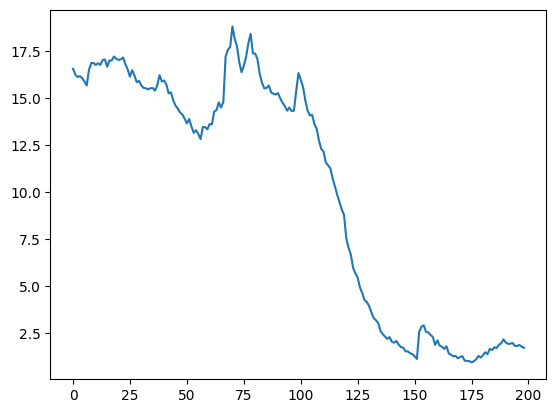

In [46]:
plt.plot([i[0] for i in mean_thicknesses])

In [ ]:
samples = ['D2016.01.05_S1181_I149_5', 'D2016.01.21_S1198_I149_7', 
'D2016.01.21_S1198_I149_9', 'D2016.01.21_S1198_I149_10',
'D2016.01.23_S1202_I149_2', 'D2016.01.23_S1202_I149_5',
 'D2016.01.23_S1202_I149_7', 'D2016.01.23_S1202_I149_11','D2016.01.28_S1206_I149_5','D2016.01.28_S1207_I149_12',
 'D2016.01.29_S1208_I149_1','D2016.01.29_S1209_I149_6',
 'D2016.01.29_S1209_I149_9',
 'D2016.01.30_S1211_I149_4',
'D2016.02.02_S1212_I149_3',
'D2016.02.02_S1213_I149_2',
'D2016.02.02_S1213_I149_3',
'D2016.02.02_S1213_I149_6',
'D2016.02.05_S1216_I149_1',
'D2016.02.05_S1216_I149_2',
'D2016.02.05_S1216_I149_3',
 ]